In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

# Sinusodial Gratings
$$g(x,y)=Asin(2πf(xcosθ+ysinθ)+ϕ)$$

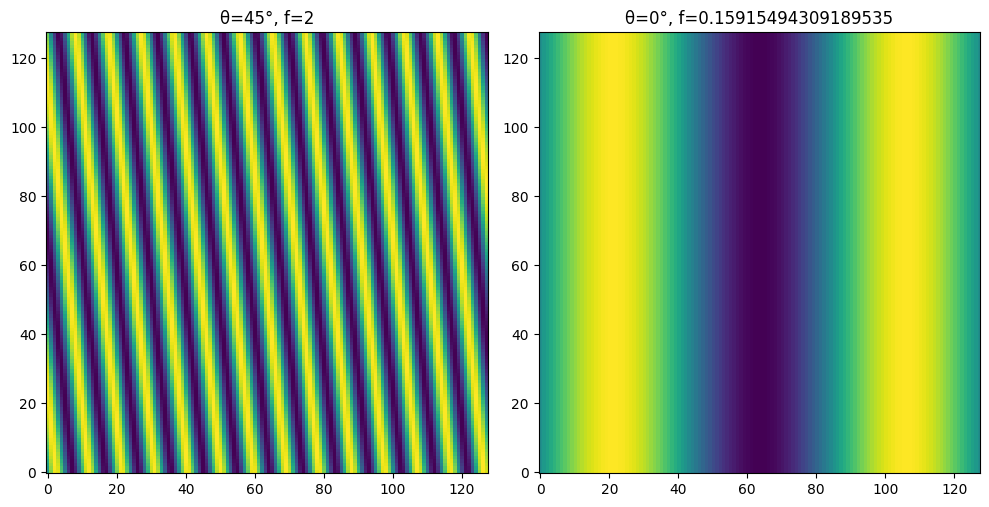

In [56]:
def sinusoidal_grating(A, f, theta, phi, grid_x, grid_y):
    '''
    Takes a grid, amplititude, frequence, phase and an angle orientation and returns the sinusoidal grating
    grid_x: (M x N)
    grid_y: (N x M)
    '''
    rotated_grid_x = grid_x * np.cos(theta) + grid_y * np.sin(theta)
    grating = A * np.sin(2 * np.pi * f * (rotated_grid_x) + phi)
    return grating


def plot_sinusoidal_grating():
    grid_size = 128
    x = np.linspace(0, 3 * np.pi, grid_size)
    y = np.linspace(0, 1, grid_size)
    phi = 0
    A = 10
    grid_x, grid_y = np.meshgrid(x, y)
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    params = [
        {'theta': np.pi/4, 'f': 2},  # 45 degrees, lower frequency
        {'theta': 0, 'f': 1/(2*np.pi)}, # horizontal at a natural sine frequency
    ]

    for ax, param in zip(axes.flat, params):
        grating = sinusoidal_grating(A, param['f'], param['theta'], phi, grid_x, grid_y)
        im = ax.imshow(grating, origin = 'lower')
        ax.set_title(f"θ={param['theta']*180/np.pi:.0f}°, f={param['f']}")

    plt.tight_layout()

plot_sinusoidal_grating()



# Drifting Sinusodial Grating
$$g(x,y,t)=Asin(2πf(xcosθ+ysinθ)+\phi-2πft)$$



In [55]:
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline


grid_size = 128
x = np.linspace(0, 10 * np.pi, grid_size)
y = np.linspace(0, 10 * np.pi, grid_size)
f = 1/(2*np.pi) # cycles per degree
time_freq = 10 # cycles per second
theta = np.pi/4 # 45 degrees
phi = 0
A = 10
frames = 100
drifting_grid = np.zeros((frames, grid_size, grid_size))

# Generate each frame with incrementing phase shift
for t in range(frames):
    # Re-use existing sinusoidal_grating function with updated phase
    phase_shift = phi - 2*np.pi*time_freq*(t/frames)
    grid_x, grid_y = np.meshgrid(x, y)
    drifting_grid[t] = sinusoidal_grating(
        A=A,
        f=f, 
        theta=theta,
        phi=phase_shift,
        grid_x=grid_x,
        grid_y=grid_y
    )

# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(8, 8))

# Initialize the plot with the first frame
im = ax.imshow(drifting_grid[0], animated=True, cmap='gray', origin = 'lower', vmin=-1, vmax=1)
ax.set_title(f"θ={theta*180/np.pi:.0f}°, f={f}")

# Animation update function
def update(frame):
    im.set_array(drifting_grid[frame])
    return [im]

# Create the animation
anim = animation.FuncAnimation(
    fig, update, frames=frames,
    interval=50, blit=True
)
plt.close()
HTML(anim.to_jshtml())



# Convolutions

### First, we implement a basic spatial grating

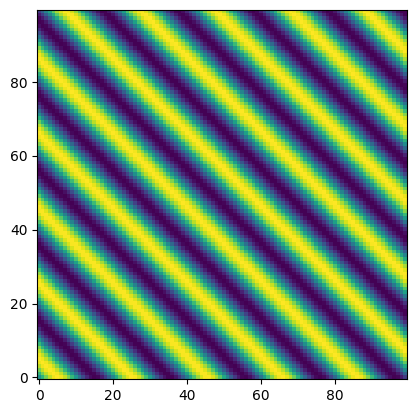

In [60]:
def spatial_grating(A: float, phi: float, f: float, theta: float, grid_size: int = 100) -> np.ndarray:
    x = np.linspace(0, 10 * np.pi, grid_size)
    y = np.linspace(0, 10 * np.pi, grid_size)
    x_grid, y_grid = np.meshgrid(x, y)
    grating = A * np.sin(2 * np.pi * f * (x_grid * np.cos(theta) + y_grid * np.sin(theta)) + phi)
    return grating

def plot_grating(grating: np.ndarray):
    fig = plt.figure()
    plt.imshow(grating, origin='lower')
    plt.show()

grating = spatial_grating(1.0, 0.0, 10 * np.pi, np.pi / 4, 100)
plot_grating(grating)


### Now, we implement a Gaussian Kernel

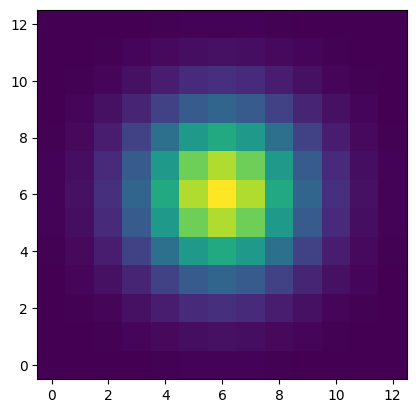

In [84]:
from typing import Tuple

def gaussian_kernel(sigma: float, size: int) -> np.ndarray:
    """
    Create a 2D Gaussian kernel with specified standard deviation and size.
    
    This function generates a square 2D Gaussian kernel that can be used for 
    image filtering/smoothing operations. The kernel is normalized so the sum 
    of all elements equals 1, ensuring that the filter preserves the overall 
    intensity of the image.
    
    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution. Controls the spread
        of the kernel. Larger values create a wider, more gradual falloff.
        Must be positive.
    size : int
        Width and height of the kernel in pixels. Must be an odd number to
        ensure the kernel is symmetric around its center pixel.
        
    Returns
    -------
    np.ndarray
        A 2D normalized Gaussian kernel of shape (size, size).
        Values are floating point numbers in range [0, 1].
        
    Raises
    ------
    ValueError
        If sigma <= 0 or if size is not an odd number.
        
    Notes
    -----
    The kernel is computed using the 2D Gaussian function:
        G(x,y) = exp(-(x² + y²)/(2σ²))
    
    where x and y are distances from the kernel center.
    
    The kernel is normalized by dividing all elements by their sum,
    ensuring that Σ G(x,y) = 1 over the entire kernel.
    
    Examples
    --------
    >>> kernel = gaussian_kernel(sigma=1.0, size=5)
    >>> print(kernel.shape)
    (5, 5)
    >>> print(np.sum(kernel))
    1.0
    """
    if sigma <= 0:
        raise ValueError("sigma must be positive")
    if size % 2 == 0:
        raise ValueError("size must be odd")

    # We use (size-1)/2 to create a symmetric range around 0.
    # For example, with size=5:
    # - We want 5 points: [-2, -1, 0, 1, 2]
    # - The middle point (0) is the kernel center
    # - We have equal number of points (2) on each side of 0
    # - Total points = 2 (left) + 1 (center) + 2 (right) = 5 
    x = np.linspace(-(size-1)/2, (size-1)/2, size)
    x_grid, y_grid = np.meshgrid(x, x)
    kernel = np.exp(-(x_grid**2 + y_grid**2) / (2 * sigma**2))
    return kernel / np.sum(kernel)

kernel = gaussian_kernel(2, 13)

figure = plt.figure()
plt.imshow(kernel, origin = 'lower')
plt.show()